In [28]:
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt





In [29]:
train = pd.read_csv('data/datasets/ais_train.csv', sep='|')
train['time'] = pd.to_datetime(train['time'])
train.info()
missing_values = train.isnull().sum()
print("Number of missing values in each column:\n", missing_values)

# Print the columns with missing values
# missing_columns = missing_values[missing_values > 0].index.tolist()
# print("Columns with missing values:", missing_columns)

train.head()

test = pd.read_csv('data/datasets/ais_test.csv', sep=',')
test['time'] = pd.to_datetime(test['time'])
test.head()

vessels = pd.read_csv('data/datasets/vessels.csv', sep='|')
vessels.head()

ports = pd.read_csv('data/datasets/ports.csv', sep='|')
ports.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   time       1522065 non-null  datetime64[ns]
 1   cog        1522065 non-null  float64       
 2   sog        1522065 non-null  float64       
 3   rot        1522065 non-null  int64         
 4   heading    1522065 non-null  int64         
 5   navstat    1522065 non-null  int64         
 6   etaRaw     1522065 non-null  object        
 7   latitude   1522065 non-null  float64       
 8   longitude  1522065 non-null  float64       
 9   vesselId   1522065 non-null  object        
 10  portId     1520450 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 127.7+ MB
Number of missing values in each column:
 time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0

,portId,name,portLocation,longitude,latitude,UN_LOCODE,countryName,ISO
0,61d36ed80a1807568ff9a064,Port of Algiers,Algiers,3.067222,36.773611,DZALG,Algeria,DZ
1,61d36ed80a1807568ff9a065,Port of Annaba,Annaba,7.772500,36.900556,DZAAE,Algeria,DZ
2,61d36edf0a1807568ff9a070,Port of Oran,Oran,-0.639722,35.712222,DZORN,Algeria,DZ
3,61d36ee00a1807568ff9a072,Port of Skikda,Skikda,6.905833,36.887500,DZSKI,Algeria,DZ
4,61d36ee10a1807568ff9a074,Port of Pago-Pago,Pago-Pago,-170.690556,-14.274167,ASPPG,American Samoa,AS


In [30]:
port_id_mapping = {port_id: idx for idx, port_id in enumerate(train['portId'].unique())}
train['portId'] = train['portId'].map(port_id_mapping)
ports['portId'] = ports['portId'].map(port_id_mapping)


vessel_id_mapping = {vessel_id: idx for idx, vessel_id in enumerate(train['vesselId'].unique())}
train['vesselId'] = train['vesselId'].map(vessel_id_mapping)
vessels['vesselId'] = vessels['vesselId'].map(vessel_id_mapping)
test['vesselId'] = test['vesselId'].map(vessel_id_mapping)

# Create a DataFrame to visualize the vessel ID mapping
vessel_id_mapping_df = pd.DataFrame(list(vessel_id_mapping.items()), columns=['Original Vessel ID', 'Mapped Vessel ID'])


shipping_line_id_mapping = {shipping_line_id: idx for idx, shipping_line_id in enumerate(vessels['shippingLineId'].unique())}
vessels['shippingLineId'] = vessels['shippingLineId'].map(shipping_line_id_mapping)

In [31]:
# vessel_id_mapping_df['Mapped Vessel ID' == 99]

In [32]:
vessels.head()

,shippingLineId,vesselId,CEU,DWT,GT,NT,vesselType,breadth,depth,draft,enginePower,freshWater,fuel,homePort,length,maxHeight,maxSpeed,maxWidth,rampCapacity,yearBuilt
0,0,599.0,6500,21200.0,58684,17606.0,83.0,32.0,22.20,NaN,0.0,NaN,NaN,OSLO,199.00,5.0,18.6,15.2,150.0,2000
1,1,65.0,4902,12325.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,MONROVIA,182.00,NaN,NaN,NaN,NaN,2006
2,2,640.0,5000,13059.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,SAINT JOHN'S,182.00,NaN,NaN,NaN,NaN,2010
3,3,255.0,4200,12588.0,39362,NaN,83.0,28.0,NaN,NaN,11060.0,NaN,NaN,NaN,167.00,NaN,NaN,NaN,NaN,2011
4,4,68.0,7450,21052.0,75528,24391.0,83.0,37.2,22.23,NaN,13140.0,491.47,3236.78,Panama,199.98,NaN,NaN,NaN,NaN,2018


In [33]:


train = train.merge(ports[['portId', 'latitude', 'longitude']], how='left', left_on='portId', right_on='portId', suffixes=('', '_port'))
train.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000


In [34]:
train = train.merge(vessels[['vesselId', 'length', 'shippingLineId', 'maxSpeed', 'breadth', 'DWT']], on='vesselId', how='left')
train['vessel_deep_sea'] = np.where(train['length'] > 200, 1, 0)

train.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port,length,shippingLineId,maxSpeed,breadth,DWT,vessel_deep_sea
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889,199.00,9,NaN,32.00,21214.0,0
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000,199.97,6,22.5,32.26,18878.0,0
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889,199.00,14,NaN,32.00,18383.0,0
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444,199.00,5,NaN,32.00,15199.0,0
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000,199.95,6,22.4,32.20,18833.0,0


Add if the vessel is on land or in ocean 
- needed to download the fila locally and not through Git 

In [35]:
# ais_ocean_info= pd.read_csv('data/datasets/ais_data.csv', sep=',')
# ais_ocean_info['portId'] = ais_ocean_info['portId'].map(port_id_mapping)
# ais_ocean_info['time'] = pd.to_datetime(ais_ocean_info['time'])
# #
# ais_ocean_info.head()

In [36]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    r = 6371  # Radius of Earth in kilometers
    return r * c  # Distance in kilometers

### Feature engineering 

In [ ]:

def feature_engineering(train):
    train = train.copy(100)
    features = pd.DataFrame()

    # Sort values by vesselId and time to ensure proper ordering
    train = train.sort_values(by=['vesselId', 'time'])

    # Add basic columns to features from train
    features['vesselId'] = train['vesselId']
    features['time'] = train['time']
    features['latitude'] = train['latitude']
    features['longitude'] = train['longitude']
    features['cog'] = train['cog']

    # Create binary 'under_way' based on navstat (1 if navstat is 0 or 8, otherwise 0)
    features['under_way'] = train['navstat'].isin([0, 8]).astype(int)

    # Calculate speed based on time and location differences
    train['speed'] = train.groupby('vesselId').apply(
        lambda x: np.sqrt((x['latitude'].diff()**2 + x['longitude'].diff()**2) / (x['time'].diff().dt.total_seconds()**2))
    ).reset_index(drop=True)
    features['speed'] = train['speed']

    # Time since last movement
    features['time_since_last_movement'] = train.groupby('vesselId')['time'].diff().dt.total_seconds().fillna(0)

    # Lag features for the last 3 positions (latitude, longitude, time)
    for i in range(1, 4):
        features[f'latitude_{i}'] = train.groupby('vesselId')['latitude'].shift(i)
        features[f'longitude_{i}'] = train.groupby('vesselId')['longitude'].shift(i)
        features[f'time_{i}'] = train.groupby('vesselId')['time'].diff(i).dt.total_seconds()

    features = features.dropna()

    # Split the time column into month, day, hour, and minute
    features['month'] = train['time'].dt.month
    features['day'] = train['time'].dt.day
    features['hour'] = train['time'].dt.hour
    features['minute'] = train['time'].dt.minute

    # Additional features like vessel type, length, shipping line, etc.
    features['vessel_deep_sea'] = train['vessel_deep_sea']
    features['shippingLineId'] = train['shippingLineId']
    features['length'] = train['length']

    features['cog'] = features['cog'].replace(360, np.nan)

    # Convert COG to radians for sine and cosine
    features['cog_rad'] = np.radians(features['cog'])

    # Calculate sine and cosine for COG
    features['cog_sin'] = np.sin(features['cog_rad'])
    features['cog_cos'] = np.cos(features['cog_rad'])

    # Add 5-day window features that reference the first row in the window
    for feature in ['speed', 'latitude', 'longitude', 'cog']:  # List features to aggregate
        features[f'{feature}_first_in_5d'] = np.nan  # Initialize the new feature column

    # Iterate through each vessel group
    for vessel_id, group in train.groupby('vesselId'):
        for idx in range(len(group)):
            # Get the reference point
            ref_time = group['time'].iloc[idx]
            # Get the range for the next 5 days from the reference point
            start_time = ref_time
            end_time = ref_time + pd.Timedelta(days=5)
            
            # Select the relevant rows in the next 5 days
            mask = (group['time'] > start_time) & (group['time'] <= end_time)
            # Retrieve the first values of the desired features within the time window
            for feature in ['speed', 'latitude', 'longitude', 'cog']:
                if not group[mask][feature].empty:  # Check if there are any values within the range
                    features.loc[group.index[idx], f'{feature}_first_in_5d'] = group[mask][feature].iloc[0]

    return features

# Test the function
features = feature_engineering(train)
features.head()


C:\Users\ingvi\AppData\Local\Temp\ipykernel_26084\2371400649.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train['speed'] = train.groupby('vesselId').apply(


In [39]:
features.head()

,time,first_latitude_ref,first_longitude_ref,first_cog_ref,under_way_ref,month_ref,day_ref,hour_ref,minute_ref,cog,cog_rad,cog_sin,cog_cos
0,2024-01-01 00:00:25,-34.74370,-57.85130,284.0,1.0,1.0,1.0,0.0,0.0,284.0,4.956735,-0.970296,0.241922
1,2024-01-01 00:00:36,8.89440,-79.47939,109.6,0.0,1.0,1.0,0.0,0.0,109.6,1.912881,0.942057,-0.335452
2,2024-01-01 00:01:45,39.19065,-76.47567,111.0,1.0,1.0,1.0,0.0,1.0,111.0,1.937315,0.933580,-0.358368
3,2024-01-01 00:03:11,-34.41189,151.02067,96.4,0.0,1.0,1.0,0.0,3.0,96.4,1.682497,0.993768,-0.111469
4,2024-01-01 00:03:51,35.88379,-5.91636,214.0,1.0,1.0,1.0,0.0,3.0,214.0,3.735005,-0.559193,-0.829038


In [265]:
def find_last_features(features):
    # Assuming that the last row for every vesselId is the most recent
    last_features = features.groupby('vesselId').last().reset_index()
    return last_features

last_features = find_last_features(features)
last_features.head()


,vesselId,time,latitude,longitude,under_way,cog,latitude_1,longitude_1,time_1,latitude_2,...,time_since_day_5,latitude_day_5,longitude_day_5,month,day,hour,minute,cog_rad,cog_sin,cog_cos
0,0,2024-05-01 12:41:57,34.57936,128.99926,1,221.5,34.59684,129.01917,335.0,34.65578,...,1291415.0,47.25845,-122.38257,5,1,12,41,3.865904,-0.662620,-0.748956
1,1,2024-04-30 10:12:01,1.24460,103.39997,1,305.1,1.22186,103.46804,1007.0,1.20238,...,2089353.0,24.98441,55.06388,4,30,10,12,5.325000,-0.818150,0.575005
2,2,2024-05-07 23:59:02,18.13873,-69.74863,1,176.0,18.14185,-69.74807,1250.0,18.14458,...,605953.0,40.69758,-74.15090,5,7,23,59,3.071779,0.069756,-0.997564
3,3,2024-04-26 13:29:25,41.64055,143.29942,1,87.6,41.63254,141.92751,14489.0,41.63043,...,636735.0,35.21809,129.40634,4,26,13,29,1.528908,0.999123,0.041876
4,4,2024-05-07 12:28:39,26.58710,121.27831,1,39.1,26.54636,121.23948,908.0,26.49491,...,1759849.0,-29.76682,31.26572,5,7,12,28,0.682424,0.630676,0.776046


### Train the model

In [266]:
# # Define features and target
y = features[['latitude', 'longitude']]  
X = features.drop(columns=['latitude', 'longitude', 'time', 'cog']) 

X.head()

,vesselId,under_way,latitude_1,longitude_1,time_1,latitude_2,longitude_2,time_2,latitude_3,longitude_3,...,time_since_day_5,latitude_day_5,longitude_day_5,month,day,hour,minute,cog_rad,cog_sin,cog_cos
412804,0,1,32.56826,-117.46225,1216.0,32.60423,-117.46227,2444.0,32.64007,-117.46339,...,3100551.0,-34.74370,-57.85130,2,5,21,16,4.340634,-0.931691,-0.363251
412959,0,1,32.53669,-117.46805,1231.0,32.56826,-117.46225,2447.0,32.60423,-117.46227,...,3079659.0,-35.16787,-56.77210,2,5,21,36,0.731293,0.667833,0.744312
413174,0,1,32.53490,-117.47044,1217.0,32.53669,-117.46805,2448.0,32.56826,-117.46225,...,3079125.0,-35.16863,-56.63185,2,5,21,57,0.382227,0.372988,0.927836
413305,0,1,32.54160,-117.46490,1210.0,32.53490,-117.47044,2427.0,32.53669,-117.46805,...,3079099.0,-35.16805,-56.53190,2,5,22,17,0.335103,0.328867,0.944376
413498,0,1,32.54949,-117.46049,1246.0,32.54160,-117.46490,2456.0,32.53490,-117.47044,...,3079324.0,-35.16715,-56.45306,2,5,22,38,0.376991,0.368125,0.929776


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# # Initialize the XGBoost model
# model = xgb.XGBRegressor()
# Define the parameter grid for RandomizedSearchCV
# param_grid = {
#     'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
#     'max_features': ['auto', 'sqrt'],
#     'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# # Initialize the RandomizedSearchCV with the RandomForestRegressor
# random_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_grid, 
#                                    n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# # Fit the random search model
# random_search.fit(X, y)

# # Get the best model from the random search
# best_model = random_search.best_estimator_


best_model = RandomForestRegressor()


# Fit the search
best_model.fit(X, y)


In [151]:
X.head()

,vesselId,under_way,time_since_last_movement,latitude_1,longitude_1,time_1,latitude_2,longitude_2,time_2,latitude_3,...,time_since_day_5,latitude_day_5,longitude_day_5,month,day,hour,minute,cog_rad,cog_sin,cog_cos
412804,0,1,1216.0,32.56826,-117.46225,1216.0,32.60423,-117.46227,2444.0,32.64007,...,3100551.0,-34.74370,-57.85130,2,5,21,16,4.340634,-0.931691,-0.363251
412959,0,1,1231.0,32.53669,-117.46805,1231.0,32.56826,-117.46225,2447.0,32.60423,...,3079659.0,-35.16787,-56.77210,2,5,21,36,0.731293,0.667833,0.744312
413174,0,1,1217.0,32.53490,-117.47044,1217.0,32.53669,-117.46805,2448.0,32.56826,...,3079125.0,-35.16863,-56.63185,2,5,21,57,0.382227,0.372988,0.927836
413305,0,1,1210.0,32.54160,-117.46490,1210.0,32.53490,-117.47044,2427.0,32.53669,...,3079099.0,-35.16805,-56.53190,2,5,22,17,0.335103,0.328867,0.944376
413498,0,1,1246.0,32.54949,-117.46049,1246.0,32.54160,-117.46490,2456.0,32.53490,...,3079324.0,-35.16715,-56.45306,2,5,22,38,0.376991,0.368125,0.929776


In [152]:

def prepare_test_for_predictions(test, last_features):
    test = test.copy()
    prepared_test = pd.DataFrame()

    # Create a time column in last_features for merging
    last_features['year'] = 2024  # Assuming 2024 as the year for the test set
    last_features['time'] = pd.to_datetime(
        last_features[['year', 'month', 'day', 'hour', 'minute']]
    )
    
    # Drop unnecessary columns from last_features
    last_features = last_features.drop(
        columns=['year', 'month', 'day', 'hour', 'minute']
    ).copy()

    # Add vesselId and time to prepared_test
    prepared_test['vesselId'] = test['vesselId']
    prepared_test['time'] = test['time']

    # Merge with last_features on vesselId to get historical data
    prepared_test = prepared_test.merge(last_features, on='vesselId', how='left', suffixes=('', '_last'))

    # Check the columns after merging
    print(prepared_test.columns)

    # Check if the necessary columns are available
    if 'time_last' not in prepared_test.columns:
        raise KeyError("Column 'time_last' not found in prepared_test DataFrame.")
    
    # Calculate the time difference for time_1 (time since last known position)
    prepared_test['time_1'] = (prepared_test['time'] - prepared_test['time_last']).dt.total_seconds()

    # Assuming latitude and longitude exist, set them correctly
    prepared_test['latitude_1'] = prepared_test['latitude']
    prepared_test['longitude_1'] = prepared_test['longitude']

    # Drop latitude and longitude after copying into latitude_1 and longitude_1
    prepared_test.drop(columns=['latitude', 'longitude'], inplace=True)

    # Extract temporal features from the test time
    prepared_test['month'] = test['time'].dt.month
    prepared_test['day'] = test['time'].dt.day
    prepared_test['hour'] = test['time'].dt.hour
    prepared_test['minute'] = test['time'].dt.minute

    # Drop the time columns after feature extraction
   

    # # Add last 5 days features (if they exist in last_features)
    # for i in range(1, 6):
    #     time_day_last_col = f'time_day_{i}_last'
    #     latitude_day_last_col = f'latitude_day_{i}_last'
    #     longitude_day_last_col = f'longitude_day_{i}_last'
        
    #     # Check if the columns exist before assigning
    #     if time_day_last_col in prepared_test.columns:
    #         prepared_test[f'time_since_day_{i}'] = (prepared_test['time'] - prepared_test[time_day_last_col]).dt.total_seconds()
        
    #     if latitude_day_last_col in prepared_test.columns:
    #         prepared_test[f'latitude_day_{i}'] = prepared_test[latitude_day_last_col]
        
    #     if longitude_day_last_col in prepared_test.columns:
    #         prepared_test[f'longitude_day_{i}'] = prepared_test[longitude_day_last_col]

    # prepared_test['speed_last_2_hours'] = prepared_test.apply(
    #     lambda row: (
    #         haversine(
    #             last_features.loc[(last_features['vesselId'] == row['vesselId']) & 
    #                               (last_features['time'] < row['time']) & 
    #                               (last_features['time'] >= row['time'] - pd.Timedelta(hours=2)), 'latitude'].values[0],
    #             last_features.loc[(last_features['vesselId'] == row['vesselId']) & 
    #                               (last_features['time'] < row['time']) & 
    #                               (last_features['time'] >= row['time'] - pd.Timedelta(hours=2)), 'longitude'].values[0],
    #             row['latitude_1'],
    #             row['longitude_1']
    #         ) / 2 if not last_features.loc[(last_features['vesselId'] == row['vesselId']) & 
    #                                         (last_features['time'] < row['time']) & 
    #                                         (last_features['time'] >= row['time'] - pd.Timedelta(hours=2))].empty else np.nan
    #     ), axis=1
    # )

    # Sine and Cosine transformations for COG
    prepared_test['cog'] = last_features['cog'].replace(360, np.nan)  # Handle unavailable COG
    prepared_test['cog_rad'] = np.radians(prepared_test['cog'])  # Convert to radians
    prepared_test['cog_sin'] = np.sin(prepared_test['cog_rad'])  # Sine transformation
    prepared_test['cog_cos'] = np.cos(prepared_test['cog_rad'])  # Cosine transformation

    prepared_test.drop(columns=['time', 'time_last', 'cog'], inplace=True)
   
    return prepared_test

# Example usage for predictions
test_df = prepare_test_for_predictions(test, last_features)
test_df.head()


Index(['vesselId', 'time', 'time_last', 'latitude', 'longitude', 'cog',
       'under_way', 'time_since_last_movement', 'latitude_1', 'longitude_1',
       'time_1', 'latitude_2', 'longitude_2', 'time_2', 'latitude_3',
       'longitude_3', 'time_3', 'time_since_day_1', 'latitude_day_1',
       'longitude_day_1', 'time_since_day_2', 'latitude_day_2',
       'longitude_day_2', 'time_since_day_3', 'latitude_day_3',
       'longitude_day_3', 'time_since_day_4', 'latitude_day_4',
       'longitude_day_4', 'time_since_day_5', 'latitude_day_5',
       'longitude_day_5', 'cog_rad', 'cog_sin', 'cog_cos'],
      dtype='object')


,vesselId,under_way,time_since_last_movement,latitude_1,longitude_1,time_1,latitude_2,longitude_2,time_2,latitude_3,...,latitude_day_5,longitude_day_5,cog_rad,cog_sin,cog_cos,month,day,hour,minute,speed_last_2_hours
0,412,0,1256.0,31.14647,-81.49789,916.0,31.14648,-81.49789,1980.0,31.14645,...,30.93470,-81.08670,3.865904,-0.662620,-0.748956,5,8,0,3,0.0
1,373,0,1762.0,14.81694,120.29625,557.0,14.81688,120.29630,3566.0,14.81691,...,35.45268,139.68915,5.325000,-0.818150,0.575005,5,8,0,6,0.0
2,181,1,1506.0,38.27895,10.78280,662.0,36.81120,10.29855,31289.0,36.81119,...,38.25137,13.38400,3.071779,0.069756,-0.997564,5,8,0,10,0.0
3,8,0,900.0,-43.53785,172.83522,1114.0,-43.53800,172.83608,2340.0,-43.53807,...,-41.27129,174.78784,1.528908,0.999123,0.041876,5,8,0,10,0.0
4,65,0,1973.0,48.53320,-6.12003,1287.0,48.53133,-6.10695,2011.0,48.55975,...,51.32310,3.21045,0.682424,0.630676,0.776046,5,8,0,12,0.0


Filtered vessel data:
     longitude_day_1  latitude_day_1  longitude_day_2  latitude_day_2  \
0          -81.49792        31.14647        -81.08598        30.93523   
143        -81.49792        31.14647        -81.08598        30.93523   
282        -81.49792        31.14647        -81.08598        30.93523   
426        -81.49792        31.14647        -81.08598        30.93523   
551        -81.49792        31.14647        -81.08598        30.93523   

     longitude_day_3  latitude_day_3  longitude_day_4  latitude_day_4  \
0          -81.08664        30.93475        -81.08634        30.93497   
143        -81.08664        30.93475        -81.08634        30.93497   
282        -81.08664        30.93475        -81.08634        30.93497   
426        -81.08664        30.93475        -81.08634        30.93497   
551        -81.08664        30.93475        -81.08634        30.93497   

     longitude_day_5  latitude_day_5  
0           -81.0867         30.9347  
143         -81.0867  

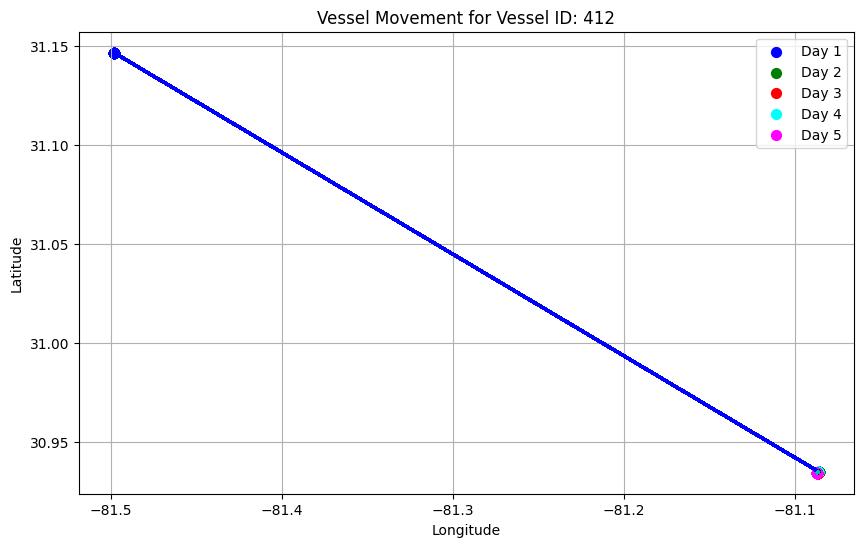

In [153]:
# import matplotlib.pyplot as plt

# Function to plot the vessel movement based on latitude and longitude
def plot_vessel_movement(data, vessel_id):
    # Filter data for the given vessel_id
    vessel_data = data[data['vesselId'] == vessel_id]
    
    # Debug: Check if there is any data for the given vessel_id
    if vessel_data.empty:
        print(f"No data found for vessel ID: {vessel_id}")
        return
    
    # Debug: Print first few rows to check the data
    print("Filtered vessel data:")
    print(vessel_data[['longitude_day_1', 'latitude_day_1', 
                       'longitude_day_2', 'latitude_day_2',
                       'longitude_day_3', 'latitude_day_3',
                       'longitude_day_4', 'latitude_day_4',
                       'longitude_day_5', 'latitude_day_5']].head())

    # Plot the positions for the last 5 days
    plt.figure(figsize=(10, 6))

    # Plotting latitude and longitude for each of the last 5 days
    plt.scatter(vessel_data['longitude_day_1'], vessel_data['latitude_day_1'], color='blue', s=50, label='Day 1')
    plt.scatter(vessel_data['longitude_day_2'], vessel_data['latitude_day_2'], color='green', s=50, label='Day 2')
    plt.scatter(vessel_data['longitude_day_3'], vessel_data['latitude_day_3'], color='red', s=50, label='Day 3')
    plt.scatter(vessel_data['longitude_day_4'], vessel_data['latitude_day_4'], color='cyan', s=50, label='Day 4')
    plt.scatter(vessel_data['longitude_day_5'], vessel_data['latitude_day_5'], color='magenta', s=50, label='Day 5')

    # Connecting lines between the points
    plt.plot([vessel_data['longitude_day_1'], vessel_data['longitude_day_2']],
             [vessel_data['latitude_day_1'], vessel_data['latitude_day_2']], 'b-', linewidth=2)  # Line Day 1 to Day 2

    plt.plot([vessel_data['longitude_day_2'], vessel_data['longitude_day_3']],
             [vessel_data['latitude_day_2'], vessel_data['latitude_day_3']], 'g-', linewidth=2)  # Line Day 2 to Day 3

    plt.plot([vessel_data['longitude_day_3'], vessel_data['longitude_day_4']],
             [vessel_data['latitude_day_3'], vessel_data['latitude_day_4']], 'r-', linewidth=2)  # Line Day 3 to Day 4

    plt.plot([vessel_data['longitude_day_4'], vessel_data['longitude_day_5']],
             [vessel_data['latitude_day_4'], vessel_data['latitude_day_5']], 'c-', linewidth=2)  # Line Day 4 to Day 5

    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Vessel Movement for Vessel ID: {vessel_id}')
    
    # Add legend to differentiate between days
    plt.legend(loc='best')
    
    # Show the plot
    plt.grid(True)  # Optional: add grid for better visibility
    plt.show()

# Example call to plot the movement of a specific vessel
plot_vessel_movement(test_df, vessel_id=412)


In [154]:
# expected_feature_names = best_model.get_booster().feature_names

# # Ensure the DataFrame has all the required columns and in the correct order
# test_df = test_df[expected_feature_names]

# Print the final DataFrame structure to ensure it's correct
print("Final test_df structure:")
# test_df = test_df.drop(columns=['vesselId'], errors='ignore')
print(test_df.head())

predictions = best_model.predict(test_df)

# Display predictions
print(predictions)

Final test_df structure:
   vesselId  under_way  time_since_last_movement  latitude_1  longitude_1  \
0       412          0                    1256.0    31.14647    -81.49789   
1       373          0                    1762.0    14.81694    120.29625   
2       181          1                    1506.0    38.27895     10.78280   
3         8          0                     900.0   -43.53785    172.83522   
4        65          0                    1973.0    48.53320     -6.12003   

   time_1  latitude_2  longitude_2   time_2  latitude_3  ...  \
0   916.0    31.14648    -81.49789   1980.0    31.14645  ...   
1   557.0    14.81688    120.29630   3566.0    14.81691  ...   
2   662.0    36.81120     10.29855  31289.0    36.81119  ...   
3  1114.0   -43.53800    172.83608   2340.0   -43.53807  ...   
4  1287.0    48.53133     -6.10695   2011.0    48.55975  ...   

   time_since_day_5  latitude_day_5  longitude_day_5  month  day  hour  \
0          520429.0        30.93470        -81.08670 

In [155]:
# predictions_df = pd.DataFrame(predictions, columns=['latitude_predicted', 'longitude_predicted'])
# predictions_df['ID'] = range(len(predictions_df))
# predictions_df = predictions_df[['ID', 'longitude_predicted', 'latitude_predicted']]

# merged_df = pd.merge(test, predictions_df, on='ID', how='left')
# merged_df.head()

   ID  vesselId                time  scaling_factor  longitude_predicted  \
0   0       412 2024-05-08 00:03:16             0.3           -81.309128   
1   1       373 2024-05-08 00:06:17             0.3           119.225822   
2   2       181 2024-05-08 00:10:02             0.3            10.623173   
3   3         8 2024-05-08 00:10:34             0.3           173.393478   
4   4        65 2024-05-08 00:12:27             0.3            -6.071518   

   latitude_predicted  
0           31.150087  
1           14.358502  
2           38.361027  
3          -42.543045  
4           48.348663  
Filtered vessel data:
     longitude_day_1  latitude_day_1  longitude_day_2  latitude_day_2  \
3          172.83529       -43.53786        172.83552       -43.53797   
253        172.83529       -43.53786        172.83552       -43.53797   
347        172.83529       -43.53786        172.83552       -43.53797   
484        172.83529       -43.53786        172.83552       -43.53797   
621        1

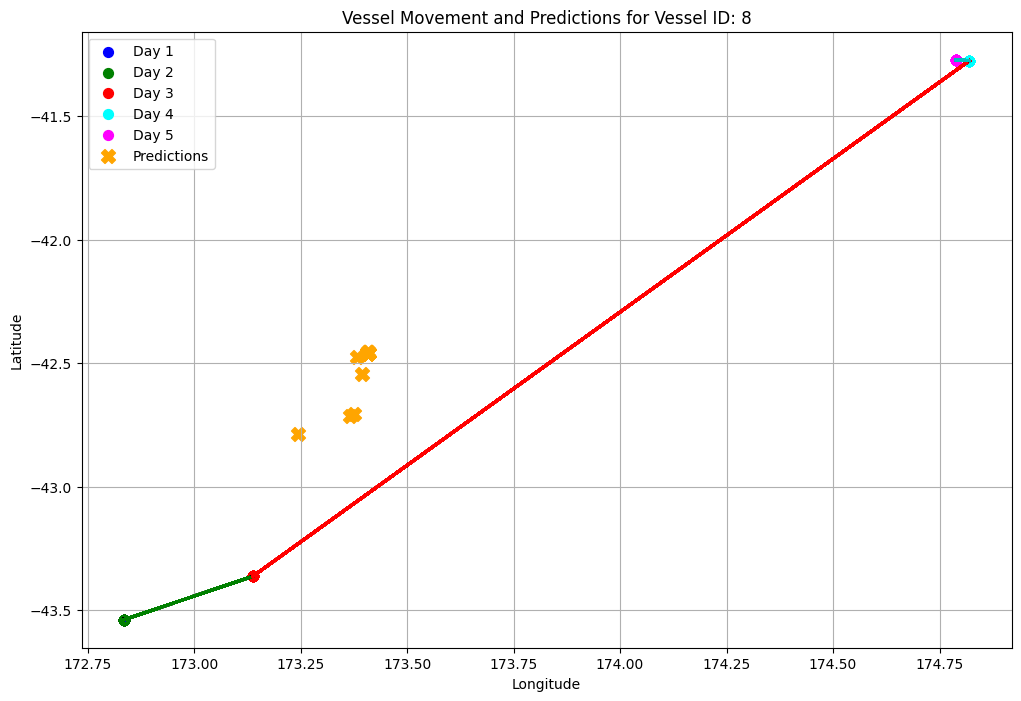

In [161]:
predictions_df = pd.DataFrame(predictions, columns=['latitude_predicted', 'longitude_predicted'])
predictions_df['ID'] = predictions_df.index
predictions_df = predictions_df[['ID', 'longitude_predicted', 'latitude_predicted']]


merged_df = pd.merge(test, predictions_df, on='ID', how='left')

print(merged_df.head())
# Function to plot the vessel movement based on latitude and longitude, including predictions

def plot_vessel_movement_with_predictions(data, predictions, vessel_id):
    # Filter data for the given vessel_id
    vessel_data = data[data['vesselId'] == vessel_id]
    
    # Debug: Check if there is any data for the given vessel_id
    if vessel_data.empty:
        print(f"No data found for vessel ID: {vessel_id}")
        return
    
    # Debug: Print first few rows to check the data
    print("Filtered vessel data:")
    print(vessel_data[['longitude_day_1', 'latitude_day_1', 
                       'longitude_day_2', 'latitude_day_2',
                       'longitude_day_3', 'latitude_day_3',
                       'longitude_day_4', 'latitude_day_4',
                       'longitude_day_5', 'latitude_day_5']].head())
    
    # Debug: Check the type and columns of predictions DataFrame
    print("Predictions DataFrame type:", type(predictions))
    print("Predictions DataFrame columns:", predictions.columns)

    # Ensure vesselId exists in predictions DataFrame
    if 'vesselId' not in predictions.columns:
        print("vesselId column not found in predictions DataFrame.")
        return

    # Filter predictions for the given vessel_id
    pred_data = predictions[predictions['vesselId'] == vessel_id]

    # Plot the positions for the last 5 days
    plt.figure(figsize=(12, 8))

    # Plotting latitude and longitude for each of the last 5 days
    plt.scatter(vessel_data['longitude_day_1'], vessel_data['latitude_day_1'], color='blue', s=50, label='Day 1')
    plt.scatter(vessel_data['longitude_day_2'], vessel_data['latitude_day_2'], color='green', s=50, label='Day 2')
    plt.scatter(vessel_data['longitude_day_3'], vessel_data['latitude_day_3'], color='red', s=50, label='Day 3')
    plt.scatter(vessel_data['longitude_day_4'], vessel_data['latitude_day_4'], color='cyan', s=50, label='Day 4')
    plt.scatter(vessel_data['longitude_day_5'], vessel_data['latitude_day_5'], color='magenta', s=50, label='Day 5')

    # Connecting lines between the points for the last 5 days
    plt.plot([vessel_data['longitude_day_1'], vessel_data['longitude_day_2']],
             [vessel_data['latitude_day_1'], vessel_data['latitude_day_2']], 'b-', linewidth=2)  # Line Day 1 to Day 2

    plt.plot([vessel_data['longitude_day_2'], vessel_data['longitude_day_3']],
             [vessel_data['latitude_day_2'], vessel_data['latitude_day_3']], 'g-', linewidth=2)  # Line Day 2 to Day 3

    plt.plot([vessel_data['longitude_day_3'], vessel_data['longitude_day_4']],
             [vessel_data['latitude_day_3'], vessel_data['latitude_day_4']], 'r-', linewidth=2)  # Line Day 3 to Day 4

    plt.plot([vessel_data['longitude_day_4'], vessel_data['longitude_day_5']],
             [vessel_data['latitude_day_4'], vessel_data['latitude_day_5']], 'c-', linewidth=2)  # Line Day 4 to Day 5

    # Plotting predictions
    if not pred_data.empty:
        plt.scatter(pred_data['longitude_predicted'], pred_data['latitude_predicted'], color='orange', s=100, label='Predictions', marker='X')
    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Vessel Movement and Predictions for Vessel ID: {vessel_id}')
    
    # Add legend to differentiate between days
    plt.legend(loc='best')
    
    # Show the plot
    plt.grid(True)  # Optional: add grid for better visibility
    plt.show()

# Example call to plot the movement of a specific vessel with predictions
plot_vessel_movement_with_predictions(test_df, merged_df, vessel_id=8)



In [157]:
# test_df.head()


# prev_vesselId = pd.DataFrame(test_df, columns = ['vesselId', 'month', 'day', 'hour', 'minute', 'longitude_1', 'latitude_1', ])

# prev_vesselId['month'] = prev_vesselId['month'].astype(int)
# prev_vesselId['day'] = prev_vesselId['day'].astype(int)
# prev_vesselId['hour'] = prev_vesselId['hour'].astype(int)
# prev_vesselId['minute'] = prev_vesselId['minute'].astype(int)
# # # Optional: Save to CSV

# prev_vesselId['time'] = pd.to_datetime({
#     'year': 2024,  # replace with the actual year if known, or make it a column if varying
#     'month': prev_vesselId['month'],
#     'day': prev_vesselId['day'],
#     'hour': prev_vesselId['hour'],
#     'minute': prev_vesselId['minute']
# })

# # Verify the new datetime column
# print(prev_vesselId[['month', 'day', 'hour', 'minute', 'time']].head())
# # prev_vesselId.drop(['month', 'day', 'hour', 'minute'])

# prev_vesselId.head()
# # print("CSV file 'data/historical_and_predicted_data.csv' has been created with both historical and predicted data.")

In [158]:
merged_df.head()

,ID,vesselId,time,scaling_factor,longitude_predicted,latitude_predicted
0,0,412,2024-05-08 00:03:16,0.3,-81.309128,31.150087
1,1,373,2024-05-08 00:06:17,0.3,119.225822,14.358502
2,2,181,2024-05-08 00:10:02,0.3,10.623173,38.361027
3,3,8,2024-05-08 00:10:34,0.3,173.393478,-42.543045
4,4,65,2024-05-08 00:12:27,0.3,-6.071518,48.348663


In [159]:
merged_df.head()
pred_vesselId = pd.DataFrame(merged_df, columns = ['vesselId', 'time', 'longitude_predicted', 'latitude_predicted'])
pred_vesselId.head()
pred_vesselId.to_csv('data/submissions/pred_vesselId.csv', index=False)


In [160]:
predictions_df.to_csv('data/submissions/predictions_11.csv', index=False)